In [5]:
import copy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

# Load data

In [6]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(800, 7)
(800,)
(800, 7)
(800,)
(800, 7)
(800,)


# Model Implementation

In [8]:
def gini(sequence):
    _, counts = np.unique(sequence, return_counts=True)
    return 1 - np.sum((counts / np.sum(counts))**2)

def entropy(sequence):
    _, counts = np.unique(sequence, return_counts=True)
    return -np.sum((counts / np.sum(counts)) * np.log2(counts / np.sum(counts)))

In [9]:
class Tree():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, feature=None, threshold=None, value=None, left=None, right=None):
        self.feature = feature
        self.threshold = threshold
        self.value = value
        self.left = left
        self.right = right

In [21]:
class DecisionTree():
    def __init__(self, criterion='gini', max_features=None, max_depth=None):
        """
            You can add/change any variables/methods to meet your need.
        """

        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth
        
        self.max_features = max_features
        self.root = None
        
        self.importance = {}
    
    def _build_tree(self, X, y, depth=0):
        if depth == self.max_depth or len(y) == 0:
            return Tree(value=np.bincount(y).argmax())

        n_samples, n_features = X.shape
        feature_idxs = np.random.choice(n_features, self.max_features, replace=False)

        best_feature = None
        best_threshold = None
        best_score = np.inf

        for feature_idx in feature_idxs:
            thresholds, classes = zip(*sorted(zip(X[:, feature_idx], y)))
            for i in range(1, n_samples):
                if classes[i-1] != classes[i]:
                    threshold = (thresholds[i-1] + thresholds[i]) / 2
                    y_left = y[X[:, feature_idx] <= threshold]
                    y_right = y[X[:, feature_idx] > threshold]
                    score = (len(y_left) * self.criterion(y_left) + len(y_right) * self.criterion(y_right)) / n_samples
                    if score < best_score:
                        best_feature = feature_idx
                        best_threshold = threshold
                        best_score = score

        if best_feature is None:
            return Tree(value=np.bincount(y).argmax())

        X_left, y_left = X[X[:, best_feature] <= best_threshold], y[X[:, best_feature] <= best_threshold]
        X_right, y_right = X[X[:, best_feature] > best_threshold], y[X[:, best_feature] > best_threshold]

        left = self._build_tree(X_left, y_left, depth+1)
        right = self._build_tree(X_right, y_right, depth+1)

        return Tree(best_feature, best_threshold, left=left, right=right)

    def fit(self, X, y):
        
        y = y.astype(int)
        n_samples, n_features = X.shape

        if self.max_features is None:
            self.max_features = n_features

        self.tree_ = self._build_tree(X, y, depth=0)
        
         # Calculate feature importance
        self.countImportance(X, y)

        return self

    def predict(self, X, y=None):
        y_pred = []
        for sample in X:
            node = self.tree_
            while node.left:
                if sample[node.feature] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            y_pred.append(node.value)
        return np.array(y_pred)

    def countImportance(self, X, y):
        total_samples = len(y)

        # Calculate impurity before the split
        if self.criterion == gini:
            parent_impurity = gini(y)
        elif self.criterion == entropy:
            parent_impurity = entropy(y)

        for feature in range(X.shape[1]):
            # Count how many samples there are for each feature value
            feature_counts = {}
            for i in range(len(X)):
                if X[i][feature] not in feature_counts:
                    feature_counts[X[i][feature]] = 0
                feature_counts[X[i][feature]] += 1

            # Calculate the weighted impurity of the split on this feature
            weighted_impurity = 0
            for feature_value, count in feature_counts.items():
                indices = np.where(X[:, feature] == feature_value)[0]
                feature_impurity = self.criterion(y[indices])
                weighted_impurity += (count / total_samples) * feature_impurity

            # Calculate the feature importance as the reduction in impurity
            self.importance[feature] = parent_impurity - weighted_impurity

In [101]:
class RandomForest():
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        
        self.trees = []
        for i in range(self.n_estimators):
            self.trees.append(DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features))
    
    def fit(self, X, y):
        if self.boostrap:
            bootstrap_size = len(X)
        else:
            bootstrap_size = None
        
        for tree in self.trees:
            bootstrap_indices = [random.randint(0, len(X)-1) for i in range(bootstrap_size)]
            bootstrap_X = X[bootstrap_indices]
            bootstrap_y = y[bootstrap_indices]
            tree.fit(bootstrap_X, bootstrap_y)
            
    def predict(self, X):
        predictions = []
        for x in X:
            tree_predictions = []
            for tree in self.trees:
                tree_predictions.append(tree.predict([x])[0])
            predictions.append(max(set(tree_predictions), key=tree_predictions.count))
        return predictions

# Questions for Decision Tree

In [11]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print("{}: entropy = {}\n{}: entropy = {}\n{}: entropy = {}\n".format(ex1, entropy(ex1), ex2, entropy(ex2), ex3, entropy(ex3)))
print("{}: gini index = {}\n{}: gini index = {}\n{}: gini index = {}\n".format(ex1, gini(ex1), ex2, gini(ex2), ex3, gini(ex3)))

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [22]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_depth3.fit(X_train, y_train)

acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)

Q2-1 max_depth=3:  0.73125


In [23]:
""" Do Not Modify Below """

from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
sk_dt.fit(X_train, y_train)
sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))

assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

In [24]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(0)

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train)

print("Q2-2 max_depth=10: ", accuracy_score(y_val, dt_depth10.predict(X_val)))

Q2-2 max_depth=10:  0.865


In [25]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0)

dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))


Q3-1 criterion='gini':  0.73125


In [26]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(0)

dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))

Q3-2 criterion='entropy':  0.77


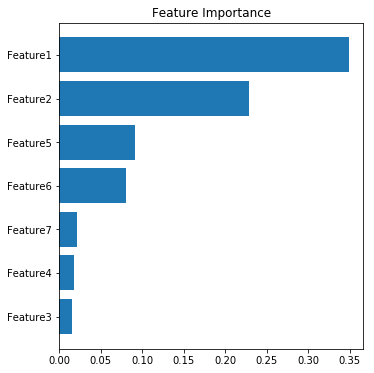

In [55]:
# For Q4

# Use simply counting to get the feature importance: dt_depth10.importance

labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']

fi = dt_depth10.importance
sorted_idx = np.argsort(fi)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, fi[sorted_idx], align="center")
plt.yticks(pos, np.array(labelList)[sorted_idx])
plt.title("Feature Importance")

plt.show()

# Questions for Random Forest

In [92]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(100)

rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q6-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

Q6-1 n_estimators=10:  0.8875


In [121]:
# For Q6-2, validation accuracy should be higher than or equal to 0.89

np.random.seed(50)

rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q6-1 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q6-1 n_estimators=50:  0.8925


In [117]:
# For Q7-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(42)

rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q7-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q7-1 max_features='sqrt':  0.89125


In [118]:
# For Q7-2, validation accuracy should be higher than or equal to 0.86

np.random.seed(0)

rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q7-1 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q7-1 max_features='All':  0.87375


# Train your own model

In [158]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

In [166]:
X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

Build your model

In [175]:
class DecisionTree():
    def __init__(self, criterion='gini', max_features=None, max_depth=None):
        """
            You can add/change any variables/methods to meet your need.
        """

        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth
        
        self.max_features = max_features
        self.root = None
        
        self.importance = {}
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape

        # Check if stopping criteria are met
        if depth >= self.max_depth or len(np.unique(y)) == 1 or n_samples == 0:
            return Node(value=np.mean(y))

        # Choose the best feature to split on
        best_feature, best_threshold = self._get_best_split(X, y)

        # Split the data
        left_indices = np.where(X[:, best_feature] <= best_threshold)[0]
        right_indices = np.where(X[:, best_feature] > best_threshold)[0]

        # Check if splitting the data resulted in an empty left or right branch
        if len(left_indices) == 0 or len(right_indices) == 0:
            return Node(value=np.mean(y))

        # Recursively build the left and right subtrees
        left = self._build_tree(X[left_indices, :], y[left_indices], depth=depth+1)
        right = self._build_tree(X[right_indices, :], y[right_indices], depth=depth+1)

        # Create a new node with the best feature and threshold
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)
    
    def _get_best_split(self, X, y):
        best_feature, best_threshold, best_impurity = None, None, 1e9

        # Randomly select a subset of features to consider for splitting
        features = np.random.choice(X.shape[1], size=self.max_features, replace=False)

        # Loop through each feature and each possible threshold value to find the best split
        for feature in features:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                # Split the data on this feature and threshold
                left_indices = np.where(X[:, feature] <= threshold)[0]
                right_indices = np.where(X[:, feature] > threshold)[0]

                # Calculate the impurity of the split using the chosen criterion
                if self.criterion == gini:
                    impurity = (len(left_indices) / len(y)) * gini(y[left_indices]) \
                               + (len(right_indices) / len(y)) * gini(y[right_indices])
                elif self.criterion == entropy:
                    impurity = (len(left_indices) / len(y)) * entropy(y[left_indices]) \
                               + (len(right_indices) / len(y)) * entropy(y[right_indices])

                # If this is the best split seen so far, update the best feature and threshold
                if impurity < best_impurity:
                    best_feature = feature
                    best_threshold = threshold
                    best_impurity = impurity

        return best_feature, best_threshold

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if self.max_features is None:
            self.max_features = n_features

        # Build the tree
        self.root = self._build_tree(X, y)
        
        # Calculate feature importance
        self.countImportance(X, y)

    def predict(self, X, y=None):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def countImportance(self, X, y):
        total_samples = len(y)

        # Calculate impurity before the split
        if self.criterion == gini:
            parent_impurity = gini(y)
        elif self.criterion == entropy:
            parent_impurity = entropy(y)

        for feature in range(X.shape[1]):
            # Count how many samples there are for each feature value
            feature_counts = {}
            for i in range(len(X)):
                if X[i][feature] not in feature_counts:
                    feature_counts[X[i][feature]] = 0
                feature_counts[X[i][feature]] += 1

            # Calculate the weighted impurity of the split on this feature
            weighted_impurity = 0
            for feature_value, count in feature_counts.items():
                indices = np.where(X[:, feature] == feature_value)[0]
                feature_impurity = self.criterion(y[indices])
                weighted_impurity += (count / total_samples) * feature_impurity

            # Calculate the feature importance as the reduction in impurity
            self.importance[feature] = parent_impurity - weighted_impurity

In [176]:
class RandomForest():
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        
        self.trees = []
        for i in range(self.n_estimators):
            self.trees.append(DecisionTree(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features))
    
    def fit(self, X, y):
        if self.boostrap:
            bootstrap_size = len(X)
        else:
            bootstrap_size = None
        
        for tree in self.trees:
            bootstrap_indices = [random.randint(0, len(X)-1) for i in range(bootstrap_size)]
            bootstrap_X = X[bootstrap_indices]
            bootstrap_y = y[bootstrap_indices]
            tree.fit(bootstrap_X, bootstrap_y)
            
    def predict(self, X):
        predictions = []
        for x in X:
            tree_predictions = []
            for tree in self.trees:
                tree_predictions.append(tree.predict([x])[0])
            predictions.append(max(set(tree_predictions), key=tree_predictions.count))
        return predictions

Train your model

In [252]:
np.random.seed(0)

your_model = RandomForest(n_estimators=20, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='entropy', max_depth=None)
your_model.fit(X_train, y_train)

print("Accuracy of my model for validation data: ", accuracy_score(y_val, your_model.predict(X_val)))

Accuracy of my model for validation data:  0.89875


In [253]:
test_pred = your_model.predict(X_test)

print("test_pred shape: ", np.array(test_pred).shape)

test_pred shape:  (800,)


In [254]:
# output csv
df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("311553009_prediction.csv")